# AI in Finance Project: Buy the Close, Sell the Open

In [1]:
#Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime as dt
import math

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from scipy.signal import find_peaks
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

In [2]:
#Silence some annoying errors
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Use decimals instead of scientific notation
np.set_printoptions(suppress=True)

In [3]:
#Set directory
# os.chdir('/Users/19052/Desktop/')

# Hypothesis

See: https://www.businessinsider.com/stocks-fall-during-regular-trading-hours-rise-overnight-2016-3 for hypothesis. The strategy here is to buy the close and sell at open next morning, the features will be 20 days of open price, close price, and volume data, as well as weekday ordinally encoded. May also add a sliding window variance feature. Target is the percent difference between next days close price, and the day after thats open price. Assuming you would need to decide a day before the trade, might also include day of open price.

# Importing Data 

In [4]:
#pulling in data, top 10 US tech stocks by market cap (omitted TSLA, because not really tech))
StackedPrices = pd.read_csv("TechStocks.csv")
StackedPrices.date = pd.to_datetime(StackedPrices.date) 
StackedPrices.PRC = abs(StackedPrices.PRC) 

#Dropping these features for now
StackedPrices = StackedPrices.drop(['PERMNO'], axis = 1)
StackedPrices = StackedPrices.drop(['BID'], axis = 1)
StackedPrices = StackedPrices.drop(['ASK'], axis = 1)
StackedPrices = StackedPrices.drop(['NUMTRD'], axis = 1)

#Added high and low of day
#StackedPrices = StackedPrices.drop(['BIDLO'], axis = 1)
#StackedPrices = StackedPrices.drop(['ASKHI'], axis = 1) 

#Remove voting shares of Google and sorting
StackedPrices = StackedPrices[StackedPrices['TICKER'] != "GOOGL"] 
StackedPrices.sort_values(by=['TICKER', 'date'], inplace=True)

StackedPrices.head()

,date,TICKER,BIDLO,ASKHI,PRC,VOL,OPENPRC
4024,2016-01-04,AAPL,102.00,105.368,105.35,69383612,102.61
4025,2016-01-05,AAPL,102.41,105.850,102.71,55791042,105.75
4026,2016-01-06,AAPL,99.87,102.370,100.70,68487388,100.56
4027,2016-01-07,AAPL,96.43,100.130,96.45,81466204,98.68
4028,2016-01-08,AAPL,96.76,99.110,96.96,70798746,98.55


In [5]:
#useful function for unpivoting tables
def MyStack(X):
    X = X.stack(dropna=False)
    X.reset_index(inplace=True)
    X.sort_values(by=['TICKER', 'date'], inplace=True)
    return(X)

In [6]:
#list of tickers
Tick = ['AAPL' , 'AMZN', 'FB', 'GOOG', 'INTC', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PYPL']

#List of values
Values = ['PRC','VOL', 'OPENPRC', 'ASKHI', 'BIDLO']

# For splitting data
TestYear = 2019

In [7]:
#Unstacking Data
UnstackedPrices = pd.pivot_table(StackedPrices, values=Values, index=['date'], columns=['TICKER'], aggfunc=np.sum)

# Feature Engineering Part 1

In [8]:
#Adding rolling window features

#20 day rolling standard deviation of price
for i in Tick:
    UnstackedPrices['20STDPRC', i] = UnstackedPrices['PRC', i].rolling(window=20).std()

#5 day rolling standard deviation of price
for ii in Tick:
    UnstackedPrices['5STDPRC', ii] = UnstackedPrices['PRC', ii].rolling(window=5).std()
    
#5 day rolling mean of price
for iii in Tick:
    UnstackedPrices['5AVGPRC', iii] = UnstackedPrices['PRC',iii].rolling(window=5).mean()
    
#5 day rolling stdev of volume
for iiii in Tick:
    UnstackedPrices['5STDVOL', iiii] = UnstackedPrices['PRC',iiii].rolling(window=5).mean()

#Open Price day of trade
OpenPrc1 = UnstackedPrices['OPENPRC'].shift(periods=-1)

for v in Tick:
    UnstackedPrices['OPENTRD', v] = OpenPrc1[v] 

In [9]:
#Saving these on the side to reassemble dataframe after its converted to numpy array with scaler
col = UnstackedPrices.columns
idx = UnstackedPrices.index

# Split train/test data
data_train = UnstackedPrices[UnstackedPrices.index.year != TestYear]
data_test = UnstackedPrices[UnstackedPrices.index.year == TestYear]

#Normalizing data
scaler = StandardScaler()
data_train_sc = scaler.fit_transform(data_train)
data_test_sc = scaler.transform(data_test)
X = np.vstack((data_train_sc, data_test_sc))

#Reassembling Dataframe
NormPrices = pd.DataFrame(X)
NormPrices.index = idx
NormPrices.columns = col
#NormPrices.head()

In [10]:
NormPrices.tail()

ASKHI                                                    \
TICKER          AAPL      AMZN        FB      GOOG      INTC      MSFT   
date                                                                     
2019-12-24  3.555799  1.597832  2.021334  2.514406  2.529464  3.996063   
2019-12-26  3.689201  1.773359  2.057812  2.581222  2.578577  4.046374   
2019-12-27  3.793773  1.845876  2.097120  2.600560  2.662202  4.086820   
2019-12-30  3.760226  1.805094  2.060644  2.530949  2.605125  4.060678   
2019-12-31  3.786173  1.733046  1.977776  2.440388  2.589196  3.999022   

                                                    ...   OPENTRD            \
TICKER          NFLX      NVDA      ORCL      PYPL  ...      AAPL      AMZN   
date                                                ...                       
2019-12-24  1.394007  1.130859  1.910244  2.482358  ...  3.624311  1.652604   
2019-12-26  1.401751  1.143284  1.846789  2.506822  ...  3.791236  1.846972   
2019-12-27  1.374907  1.143530  1.876401  2.528291  ...  3.747252  1.825805   
2019-12-30  1.327817  1.092601  1.810830  2.499333  ...  3.759705  1.749871   
2019-12-31  1.284446  1.086143  1.707187  2.441917  ...       NaN       NaN   

                                                                        \
TICKER            FB      GOOG      INTC      MSFT      NFLX      NVDA   
date                                                                     
2019-12-24  2.048295  2.571391  2.618114  4.061271  1.435725  1.165114   
2019-12-26  2.159334  2.674391  2.685753  4.155538  1.418768  1.178095   
2019-12-27  2.130357  2.594844  2.696576  4.132445  1.378648  1.130541   
2019-12-30  1.992036  2.473045  2.646523  4.021869  1.305440  1.067009   
2019-12-31       NaN       NaN       NaN       NaN       NaN       NaN   

                                
TICKER          ORCL      PYPL  
date                            
2019-12-24  1.893169  2.542528  
2019-12-26  1.938037  2.595057  
2019-12-27  1.882486  2.562283  
2019-12-30  1.705147  2.461987  
2019-12-31       NaN       NaN  

[5 rows x 100 columns]

# Visualization & Exploration

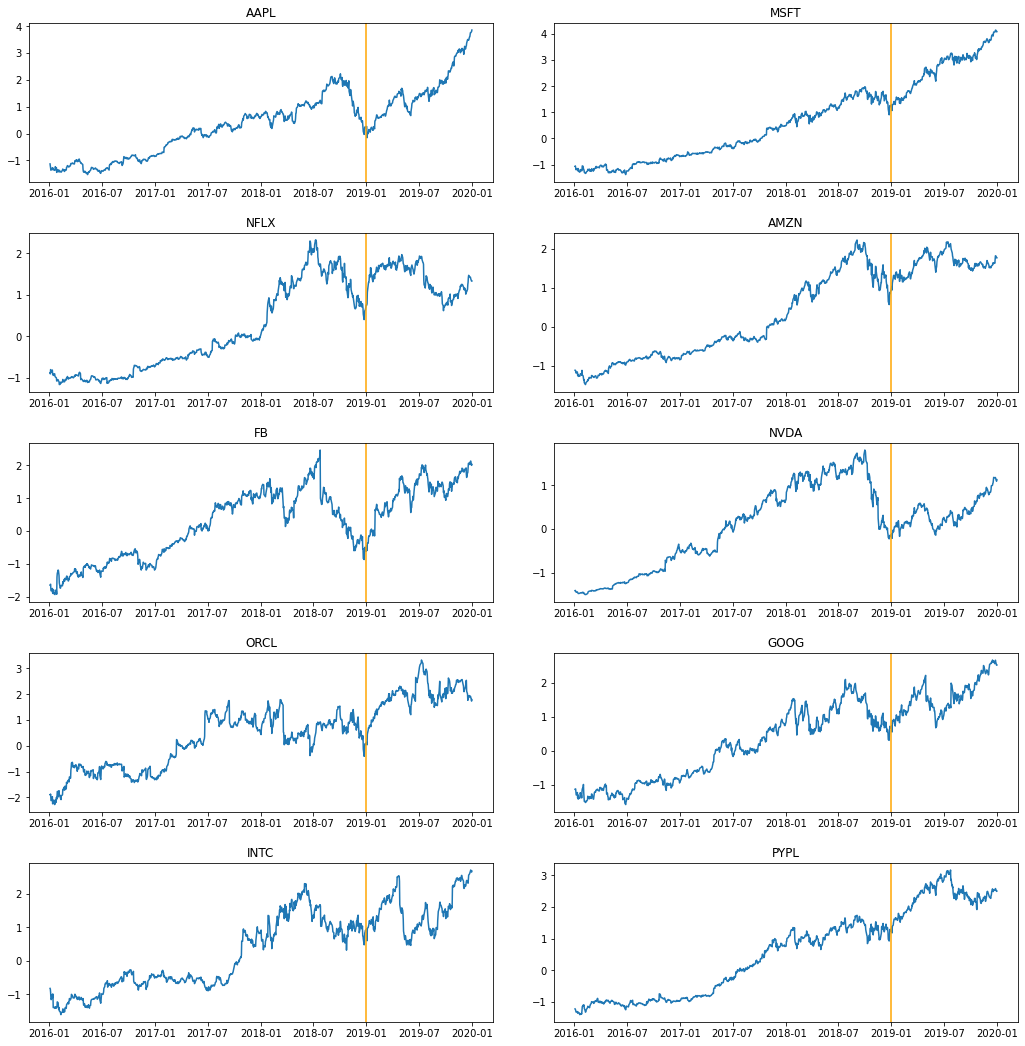

In [11]:
#Subplots of alls stocks
Tick = ['AAPL' , 'AMZN', 'FB', 'GOOG', 'INTC', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PYPL']

fig, axs = plt.subplots(5, 2,figsize=(15,15))
fig.tight_layout(pad=3.0)

for i in range(len(Tick)):
    axs[i%5, i%2].plot(NormPrices['PRC',Tick[i]])
    axs[i%5, i%2].set_title(Tick[i])
    #Added in line where test data will be split
    axs[i%5, i%2].axvline(dt.datetime(2018, 12, 31), color='orange')


In [12]:
#To check how many Nulls etc
#UnstackedPrices.info()

In [13]:
#To examine values and distibutions/ make sure normalizaiton worked
#UnstackedPrices.describe()

# Feature Engineering Part 2

In [14]:
#Feature names to lag, and steps to lag by
Feat = ['PRC','VOL', 'OPENPRC',  'ASKHI', 'BIDLO', 'WKDY'] 
Steps = 20

In [15]:
#Trimming data
NormPrices = NormPrices[:-2] #drop two rows, used to calculate returns
NormPrices = NormPrices[20:] #drop 20 rows, used to calculate volatility

#Need this for unlagged variables
NormPrices2 = NormPrices[Steps:] #trim data used to calculate lags
NormPrices2 = NormPrices2.stack(dropna=False)
NormPrices2 = pd.DataFrame(NormPrices2)
NormPrices2.reset_index(inplace=True)
NormPrices2.sort_values(by=['TICKER', 'date'], inplace=True)

#Unlagged variables, saving for later 
OPENTRD = NormPrices2['OPENTRD']
FIVESTDPRC = NormPrices2['5STDPRC']
TWENTYSTDPRC = NormPrices2['20STDPRC']
AVGPRC = NormPrices2['5AVGPRC']
STDVOL = NormPrices2['5STDVOL']

#Restacking Data
NormPrices = MyStack(NormPrices)

#Adding day of week
NormPrices['WKDY'] = NormPrices['date'].dt.dayofweek #lag or dont lag weekeday???
NormPrices.reset_index(inplace=True, drop=True)

In [16]:
#Function to add lagged variables based on steps, and assembles data frame
def LagVar(X, steps, values):
    
    UnstackX = pd.pivot_table(X, values=values, index=['date'], columns=['TICKER'], aggfunc=np.sum)
    UnstackXTrim = UnstackX[steps:]
    UnstackXTrim  = MyStack(UnstackXTrim)
    UnstackXTrim.reset_index(inplace=True, drop=True)
    
    X = UnstackXTrim
    
    for i in range(steps):
 
        Shifted1 = UnstackX.shift(periods=i+1)
        Shifted1 = Shifted1[steps:]
        Shifted2 = Shifted1.stack(dropna=False)
        Shifted2.reset_index(inplace=True)
        Shifted2.sort_values(by=['TICKER', 'date'], inplace=True)
        Shifted2.reset_index(inplace=True, drop=True)
        Shifted3 = Shifted2.add_prefix(('Lag_' + str(i+1) + '_' ))
        Shifted3.drop([('Lag_' + str(i+1) + '_date' )], axis=1, inplace=True)
        Shifted3.drop([('Lag_' + str(i+1) + '_TICKER' )], axis=1, inplace=True)

        X = pd.concat([X, Shifted3], axis = 1)
    
    return(X)

In [17]:
#Lagging data
LagData = LagVar(NormPrices, Steps, Feat) 
LagData.reset_index(inplace=True, drop=True)
LagData.head() #Check for NaNs

,date,TICKER,ASKHI,BIDLO,OPENPRC,PRC,VOL,WKDY,Lag_1_ASKHI,Lag_1_BIDLO,...,Lag_19_OPENPRC,Lag_19_PRC,Lag_19_VOL,Lag_19_WKDY,Lag_20_ASKHI,Lag_20_BIDLO,Lag_20_OPENPRC,Lag_20_PRC,Lag_20_VOL,Lag_20_WKDY
0,2016-03-02,AAPL,-1.266602,-1.261195,-1.256156,-1.252633,-0.004563,2,-1.269747,-1.320653,...,-1.402013,-1.369251,0.838201,2.0,-1.393714,-1.404751,-1.390895,-1.418814,0.269771,1.0
1,2016-03-03,AAPL,-1.245114,-1.239501,-1.254303,-1.232755,0.244027,3,-1.266602,-1.261195,...,-1.379248,-1.362625,0.866888,3.0,-1.372748,-1.410107,-1.402013,-1.369251,0.838201,2.0
2,2016-03-04,AAPL,-1.191645,-1.214861,-1.206920,-1.192734,0.843501,4,-1.245114,-1.239501,...,-1.361777,-1.431005,0.863348,4.0,-1.359905,-1.380378,-1.379248,-1.362625,0.866888,3.0
3,2016-03-07,AAPL,-1.215757,-1.225842,-1.206390,-1.222948,0.175583,0,-1.191645,-1.214861,...,-1.451514,-1.404766,1.361416,0.0,-1.370651,-1.420552,-1.361777,-1.431005,0.863348,4.0
4,2016-03-08,AAPL,-1.243801,-1.240840,-1.249009,-1.245212,-0.109882,1,-1.215757,-1.225842,...,-1.420807,-1.405296,0.726635,1.0,-1.402625,-1.437961,-1.451514,-1.404766,1.361416,0.0


In [18]:
LagData.tail() #Check for NaNs if issue

,date,TICKER,ASKHI,BIDLO,OPENPRC,PRC,VOL,WKDY,Lag_1_ASKHI,Lag_1_BIDLO,...,Lag_19_OPENPRC,Lag_19_PRC,Lag_19_VOL,Lag_19_WKDY,Lag_20_ASKHI,Lag_20_BIDLO,Lag_20_OPENPRC,Lag_20_PRC,Lag_20_VOL,Lag_20_WKDY
9635,2019-12-20,PYPL,2.500332,2.569228,2.553239,2.528225,0.305868,4,2.466381,2.534768,...,2.231083,2.174361,-0.465589,4.0,2.243207,2.261659,2.235136,2.213904,-0.219171,3.0
9636,2019-12-23,PYPL,2.491844,2.582087,2.541589,2.521128,-0.874720,0,2.500332,2.569228,...,2.203730,2.310228,-0.034317,0.0,2.181297,2.188110,2.231083,2.174361,-0.465589,4.0
9637,2019-12-24,PYPL,2.482358,2.582087,2.520821,2.525184,-1.550875,1,2.491844,2.582087,...,2.326312,2.398948,1.061867,1.0,2.248199,2.257030,2.203730,2.310228,-0.034317,0.0
9638,2019-12-26,PYPL,2.506822,2.591859,2.545641,2.578922,-1.011254,3,2.482358,2.582087,...,2.432177,2.477528,-0.213383,2.0,2.358539,2.382527,2.326312,2.398948,1.061867,1.0
9639,2019-12-27,PYPL,2.528291,2.608832,2.598168,2.561178,-1.163451,4,2.506822,2.591859,...,2.486883,2.490710,-0.921634,4.0,2.431432,2.500822,2.432177,2.477528,-0.213383,2.0


# Target

In [19]:
#Close price from next day
ClosePrc = UnstackedPrices['PRC'].shift(periods=-1)
ClosePrc = ClosePrc[:-2]
ClosePrc = ClosePrc[Steps+20:]
ClosePrc = ClosePrc.stack(dropna=False)
ClosePrc = pd.DataFrame(ClosePrc)
ClosePrc.reset_index(inplace=True)
ClosePrc.sort_values(by=['TICKER', 'date'], inplace=True)
ClosePrc.rename({0: 'PRC'}, axis=1, inplace = True)

#Open price from day after
OpenPrc2 = UnstackedPrices['OPENPRC'].shift(periods=-2)
OpenPrc2 = OpenPrc2[:-2]
OpenPrc2 = OpenPrc2[Steps+20:]
OpenPrc2 = OpenPrc2.stack(dropna=False)
OpenPrc2 = pd.DataFrame(OpenPrc2)
OpenPrc2.reset_index(inplace=True)
OpenPrc2.sort_values(by=['TICKER', 'date'], inplace=True)
OpenPrc2.rename({0: 'OPENPRC'}, axis=1, inplace = True)

In [20]:
#Calculating Log Returns
OpenPrc2['ClosePrc'] = ClosePrc['PRC']
OpenPrc2['Returns'] = np.log(OpenPrc2['OPENPRC']/OpenPrc2['ClosePrc'])
Returns = pd.DataFrame(OpenPrc2['Returns'])
Returns.reset_index(inplace=True, drop=True)

array([[<AxesSubplot:title={'center':'Returns'}>]], dtype=object)

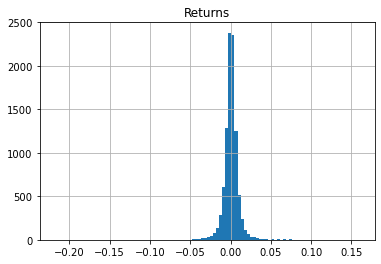

In [21]:
#Distribution of returns
Returns.hist(bins=100)

In [22]:
#Add year for splitting based on year
LagData['YEAR'] = LagData['date'].dt.year

#Adding back unlagged variables
LagData['RET'] = Returns 
LagData['OPENTRD'] = OPENTRD
LagData['5STDPRC'] = FIVESTDPRC
LagData['20STDPRC'] = TWENTYSTDPRC
LagData['5AVGPRC'] = AVGPRC
LagData['5STDVOL'] = STDVOL

In [23]:
LagData.head()

,date,TICKER,ASKHI,BIDLO,OPENPRC,PRC,VOL,WKDY,Lag_1_ASKHI,Lag_1_BIDLO,...,Lag_20_PRC,Lag_20_VOL,Lag_20_WKDY,YEAR,RET,OPENTRD,5STDPRC,20STDPRC,5AVGPRC,5STDVOL
0,2016-03-02,AAPL,-1.266602,-1.261195,-1.256156,-1.252633,-0.004563,2,-1.269747,-1.320653,...,-1.418814,0.269771,1.0,2016,0.008535,-1.257315,0.177648,-0.775594,-1.320622,-1.320622
1,2016-03-03,AAPL,-1.245114,-1.239501,-1.254303,-1.232755,0.244027,3,-1.266602,-1.261195,...,-1.369251,0.838201,2.0,2016,-0.006037,-1.249616,-0.181427,-0.102754,-1.282946,-1.282946
2,2016-03-04,AAPL,-1.191645,-1.214861,-1.206920,-1.192734,0.843501,4,-1.245114,-1.239501,...,-1.362625,0.866888,3.0,2016,-0.010758,-1.362924,-0.372550,-0.022999,-1.431693,-1.431693
3,2016-03-07,AAPL,-1.215757,-1.225842,-1.206390,-1.222948,0.175583,0,-1.191645,-1.214861,...,-1.431005,0.863348,4.0,2016,0.002768,-1.271137,-0.211773,-0.601101,-1.330781,-1.330781
4,2016-03-08,AAPL,-1.243801,-1.240840,-1.249009,-1.245212,-0.109882,1,-1.215757,-1.225842,...,-1.404766,1.361416,0.0,2016,0.002864,-1.207542,-0.201640,-0.639447,-1.367950,-1.367950


# Splitting Data

In [24]:
#Splitting data, 2019 is test set
X_train = LagData[LagData['YEAR'] != TestYear]
X_train.drop(['RET', 'YEAR', 'date', 'TICKER'], axis=1, inplace=True)
tick_train = LagData[LagData['YEAR'] != TestYear]['TICKER']

y_train = LagData[LagData['YEAR'] != TestYear]
y_train = y_train['RET']

X_test = LagData[LagData['YEAR'] == TestYear]
X_test.drop(['RET', 'YEAR', 'date', 'TICKER'], axis=1, inplace=True)
tick_test = LagData[LagData['YEAR'] == TestYear]['TICKER']

y_test = LagData[LagData['YEAR'] == TestYear]
y_test = y_test['RET']

# Feature Selection

5.587745257405553e-06 1.0988656138664663 6.0261828140174005


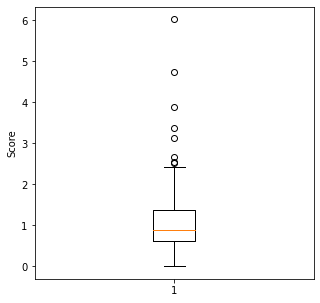

In [25]:
# Select k Best features
kbest = SelectKBest(score_func=f_regression, k='all')
fs = kbest.fit(X_train, y_train)
fs_scores = fs.scores_

print(min(fs_scores), np.mean(fs_scores), max(fs_scores))

fig = plt.figure(figsize =(5, 5)) 
plt.boxplot(fs_scores) 
plt.ylabel("Score")
plt.show() 

<AxesSubplot:>

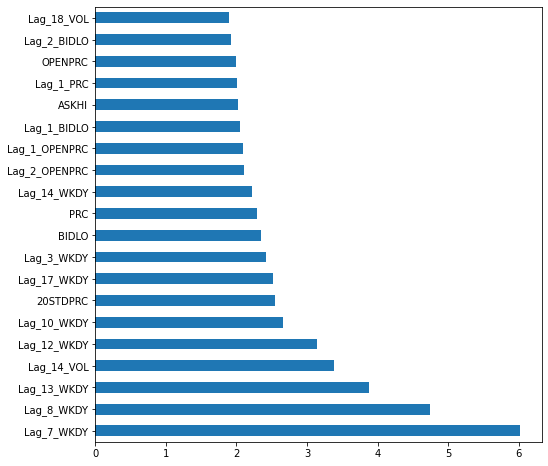

In [26]:
#Feature Importance
fs_scores_plt = pd.Series(fs_scores, index=X_train.columns)
fs_scores_plt.nlargest(20).plot(kind='barh', figsize=(8,8))

In [27]:
# Only select features with a score greater than the mean
feat_thresh = np.mean(fs_scores)
mask = fs_scores>feat_thresh
kbest_feat = X_train.columns[mask]
print(str(len(kbest_feat)) + " features selected")

52 features selected


In [28]:
kbest = SelectKBest(score_func=f_regression, k=len(kbest_feat))
fs = kbest.fit(X_train, y_train)
# Transform train and test data
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

# Model Implementation

In [29]:
# Helper functions for model evaluation

# Most scores are already implemented, just have to implement sMAPE
def smape(actual, predicted):
    n = len(actual)
    return 50/n * np.sum(2 * np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted)))

# Calculate all metrics
def calc_metrics(actual, predicted):
    rmse = mean_squared_error(actual, predicted, squared=False)
    s = smape(actual, predicted)
    return [rmse, s]

## Linear Regression (Ridge)

In [30]:
# Set up hyperparameter tuning for Ridge Regression
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10]
fit_intercept = [False]

lr_grid = {'alpha': alpha,
           'fit_intercept': fit_intercept}
print(lr_grid)

# Initialize model
lr = Ridge()
# Random search of parameters, using 3 fold cross validation, 
cv = GridSearchCV(lr, lr_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs = -1)
# Fit the random search model
cv.fit(X_train, y_train)

# Get best model
print(cv.best_params_)

{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'fit_intercept': [False]}
{'alpha': 10, 'fit_intercept': False}


In [31]:
# Re-train on full dataset using best parameters
lr_best = Ridge(alpha = 1, fit_intercept = False, random_state=42)
# Fit on train data
lr_best.fit(X_train, y_train)

Ridge(alpha=1, fit_intercept=False, random_state=42)

In [32]:
# Evaluate performance on train and test data

# Predictions for train data
y_train_pred = lr_best.predict(X_train)
lr_train_perf = calc_metrics(y_train, y_train_pred)
print(lr_train_perf)
# Predictions for test data
y_test_pred = lr_best.predict(X_test)
lr_test_perf = calc_metrics(y_test, y_test_pred)
print(lr_test_perf)

[0.011422217067167947, 79.72386477702665]
[0.011836055240997229, 82.89514458210085]


Text(0.5, 1.0, 'Top 15 Features')

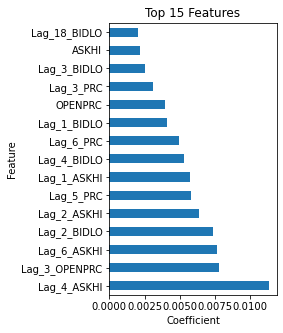

In [33]:
#Feature Importance
feat_importances = pd.Series(lr_best.coef_, index=kbest_feat)
ax = feat_importances.nlargest(15).plot(kind='barh', figsize=(3,5))
ax.set_xlabel("Coefficient")
ax.set_ylabel("Feature")
ax.set_title("Top 15 Features")

## Random Forest

In [34]:
# Set up hyperparameter tuning for Random Forest
# Number of trees in random forest
n_estimators = [25, 50, 75, 100]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2, 3, 5, 7, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [10, 20, 30, 40, 50]
# Method of selecting samples for training each tree
bootstrap = [True]

rf_grid = {'n_estimators': n_estimators,
           'max_features': max_features,
           'max_depth': max_depth,
           'min_samples_leaf': min_samples_leaf,
           'bootstrap': bootstrap}
print(rf_grid)

# Initialize model
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
cv = GridSearchCV(rf, rf_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs = -1)
# Fit the random search model
cv.fit(X_train, y_train)

# Get best model
print(cv.best_params_)

{'n_estimators': [25, 50, 75, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 3, 5, 7, 10], 'min_samples_leaf': [10, 20, 30, 40, 50], 'bootstrap': [True]}
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 75}


In [35]:
# Re-train on full dataset using best parameters
rf_best = RandomForestRegressor(n_estimators = 75, 
                                min_samples_leaf = 10,
                                max_features = 'auto',
                                max_depth = 10,
                                bootstrap = True,
                                random_state=42)
# Fit on train data
rf_best.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=50, n_estimators=75,
                      random_state=42)

In [36]:
# Evaluate performance on train and test data

# Predictions for train data
y_train_pred = rf_best.predict(X_train)
rf_train_perf = calc_metrics(y_train, y_train_pred)
print(rf_train_perf)
# Predictions for test data
y_test_pred = rf_best.predict(X_test)
rf_test_perf = calc_metrics(y_test, y_test_pred)
print(rf_test_perf)

[0.011000812481000972, 75.65151110572329]
[0.011429075899689625, 80.11437659093228]


Text(0.5, 1.0, 'Top 15 Features')

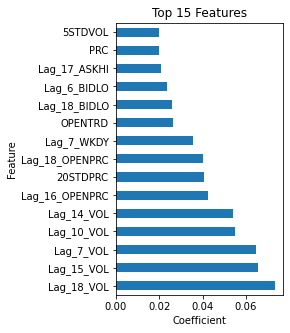

In [37]:
#Feature Importance
feat_importances = pd.Series(rf_best.feature_importances_, index=kbest_feat)
ax = feat_importances.nlargest(15).plot(kind='barh', figsize=(3,5))
ax.set_xlabel("Coefficient")
ax.set_ylabel("Feature")
ax.set_title("Top 15 Features")

## Gradient Boosted Trees

In [38]:
# Set up hyperparameter tuning for Gradient Boosted Trees (XGBoost)

# Number of trees 
n_estimators = [25, 50, 75, 100]
# Maximum number of levels in tree
max_depth = [3, 5, 7, 10]
# Learning rate to prevent overfitting
learning_rate = [0.1, 0.2, 0.3, 0.4]

xgb_grid = {'n_estimators': n_estimators,
            'max_depth': max_depth,
            'learning_rate': learning_rate}
print(xgb_grid)

# Initialize model
xgbreg = XGBRegressor(nthreads=-1)
# Random search of parameters, using 3 fold cross validation, 
cv = GridSearchCV(xgbreg, xgb_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)  
# Fit the random search model
cv.fit(X_train, y_train)

# Get best model
print(cv.best_params_)

{'n_estimators': [25, 50, 75, 100], 'max_depth': [3, 5, 7, 10], 'learning_rate': [0.1, 0.2, 0.3, 0.4]}
[20:17:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 25}


In [39]:
# Re-train on full dataset using best parameters
xgbreg_best = XGBRegressor(n_estimators = 25, max_depth = 3, learning_rate = 0.3, random_state=42)

xgbreg_best.fit(X_train, y_train)

[20:17:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.3, n_estimators=25, random_state=42)

In [40]:
# Evaluate performance on train and test data

# Predictions for train data
y_train_pred = xgbreg_best.predict(X_train)
xgb_train_perf = calc_metrics(y_train, y_train_pred)
print(xgb_train_perf)

# Predictions for test data
y_test_pred = xgbreg_best.predict(X_test)
xgb_test_perf = calc_metrics(y_test, y_test_pred)
print(xgb_test_perf)

[0.0107140007541385, 77.9488961453767]
[0.02391377404530959, 79.46252172604288]


Text(0.5, 1.0, 'Top 15 Features')

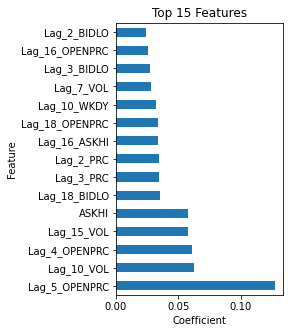

In [41]:
#Feature Importance
feat_importances = pd.Series(xgbreg_best.feature_importances_, index=kbest_feat)
ax = feat_importances.nlargest(15).plot(kind='barh', figsize=(3,5))
ax.set_xlabel("Coefficient")
ax.set_ylabel("Feature")
ax.set_title("Top 15 Features")

# Model Performance

In [42]:
# Predictive performance on test data
df_model_perf = pd.DataFrame(columns=['Model','Train RMSE','Train sMAPE','Test RMSE','Test sMAPE'])
df_model_perf.loc[0] = ['LR']+lr_train_perf+lr_test_perf
df_model_perf.loc[1] = ['RF']+rf_train_perf+rf_test_perf
df_model_perf.loc[2] = ['GBT']+xgb_train_perf+xgb_test_perf
df_model_perf

,Model,Train RMSE,Train sMAPE,Test RMSE,Test sMAPE
0,LR,0.011422,79.723865,0.011836,82.895145
1,RF,0.011001,75.651511,0.011429,80.114377
2,GBT,0.010714,77.948896,0.023914,79.462522


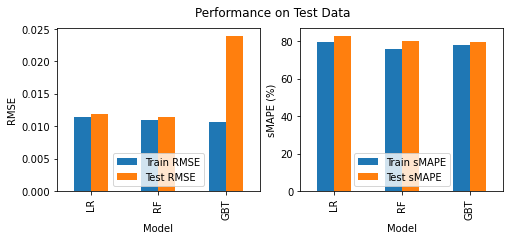

In [43]:
# Plot performance metrics
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
fig.suptitle('Performance on Test Data')
df_model_perf.plot.bar(x='Model', y=['Train RMSE','Test RMSE'], ax=axes[0], ylabel='RMSE')
df_model_perf.plot.bar(x='Model', y=['Train sMAPE','Test sMAPE'], ax=axes[1], ylabel='sMAPE (%)')
axes[0].legend(loc = 'lower center')

# Backtesting

In [44]:
def prep_data(best_mdl):
    #Adding Prediction to test data
    TestData = LagData[LagData['YEAR'] == TestYear]
    TestData['PREDRET'] = best_mdl.predict(X_test)

    #Unstacking test data for backtesting
    col = ['date', 'TICKER', 'RET', 'PREDRET']
    UnstackTest = TestData[col]
    UnstackTest = pd.pivot_table(UnstackTest, values=['RET', 'PREDRET'], index=['date'], \
                                 columns=['TICKER'], aggfunc=np.sum)

    #Setting up training data for backtesting optimization
    TrainData = LagData[LagData['YEAR'] != TestYear]
    TrainData['PREDRET'] = best_mdl.predict(X_train)

    #Unstacking train data for backtesting
    col = ['date', 'TICKER', 'RET', 'PREDRET']
    UnstackTrain = TrainData[col]
    UnstackTrain = pd.pivot_table(UnstackTrain, values=['RET', 'PREDRET'], index=['date'], \
                                  columns=['TICKER'], aggfunc=np.sum)
    
    return UnstackTest, UnstackTrain

In [45]:
#Backtesting function
def BackTest(X, Threshold, short=False):
    Tick = ['AAPL' , 'AMZN', 'FB', 'GOOG', 'INTC', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PYPL']
    
    for Tick in Tick:
        #Applying signal for each asset if threshold is passed
        X['SIGNAL', Tick] = 0
        
        #Apply buy signal
        mask = (X['PREDRET',Tick] > Threshold)
        X['SIGNAL', Tick][mask] = 1 
        
        if short == True:
            #Apply sell signal
            mask = (X['PREDRET',Tick] < -Threshold)
            X['SIGNAL', Tick][mask] = -1 
        
        #Calculating Returns based on signals
        X['TRADERET', Tick] = X['SIGNAL', Tick] * X['RET', Tick] 
    
    #Calculating returns
    X['HOLDINGS'] = (X['SIGNAL'].abs()).sum(axis=1) #Number of assets bought each day, used to find average return
    X['TOTRET'] = (X['TRADERET'].sum(axis=1) / X['HOLDINGS']) #total returns by number of holding, this is portfolio returns
    X['TOTRET'] = X['TOTRET'].fillna(0) 
    
    #Cummulative Returns
    X['STRAT_CUMRET'] = X['TOTRET'].cumsum() #Cummulative Returns
    X['LONG_CUMRET'] = (X['RET'].sum(axis=1)/10).cumsum() #Returns for equal position long portfolio
    
    #Strategy metrics
    strat_ann_vol = X['TOTRET'].std()*math.sqrt(252)
    strat_ann_ret = ((X['TOTRET'].mean()+1)**252) - 1
    strat_ann_sr = X['TOTRET'].mean()/(X['TOTRET'].std())*math.sqrt(252) #Sharpes Ratio
    strat_ann_cagr = (1 + X['STRAT_CUMRET'][-1]) ** (252 / len(X['TOTRET'])) - 1  #CAGR
    
    #Baseline Long Portfolio metrics
    long_ann_vol = (X['RET'].sum(axis=1)/10).std()*math.sqrt(252)
    long_ann_ret = (((X['RET'].sum(axis=1)/10).mean()+1)**252) - 1
    long_ann_sr = (X['RET'].sum(axis=1)/10).mean()/((X['RET'].sum(axis=1)/10).std())*math.sqrt(252)
    long_ann_cagr = (1 + X['LONG_CUMRET'][-1]) ** (252 / len(X['RET'])) - 1 
    
    return(X, strat_ann_vol, strat_ann_ret, strat_ann_sr, strat_ann_cagr, \
           long_ann_vol, long_ann_ret, long_ann_sr, long_ann_cagr)

In [46]:
#optimizing threshold parameter based on training data
def BackTestOpt(X):

    lin = np.linspace(0, 0.005, 200)
    returns = []
    
    #Testing Various Thresholds
    for i in lin:
        Y, strat_ann_vol, strat_ann_ret, strat_ann_sr, strat_ann_cagr, \
            long_ann_vol, long_ann_ret, long_ann_sr, long_ann_cagr \
            = BackTest(X, i)
        returns.append(strat_ann_ret)
    
    
    df = (pd.DataFrame([lin, returns])).T
    df.columns = ['Threshold','Returns']
    df['rollavg'] = df['Returns'].rolling(window=5).mean() #Smoothing out bumps
    
    #Finding threshold with max returns
    idx = df['rollavg'].idxmax()
    val1 = df['Returns'][idx]
    val2 = df['Threshold'][idx]
    
    #Plotting Threshold vs annualized Returns
    df.index = df['Threshold']
    df['Returns'].plot()
    df['rollavg'].plot()
    
    return(val1, val2)

## Linear Regression

In [47]:
XTrade_lr, Xopt_lr = prep_data(lr_best)

0.00073


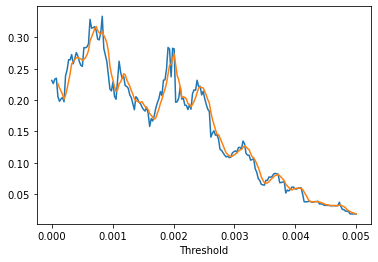

In [48]:
#Find optimal threshold based on train data, doesnt really work since model knows this data too well, cant generalize this threshold
ret, thresh = BackTestOpt(Xopt_lr)
print(round(thresh,5))

0.0001


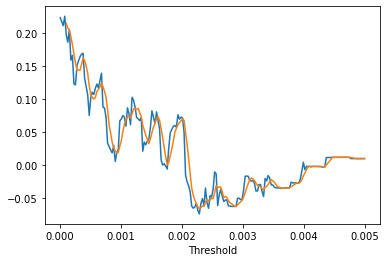

In [49]:
#Finding Optimal Threshold based on test data, cant do this in reality, would need to have other sets of data to optimize threshold on
ret, thresh = BackTestOpt(XTrade_lr)
print(round(thresh,5))

## Random Forest

In [50]:
XTrade_rf, Xopt_rf = prep_data(rf_best)

0.00163


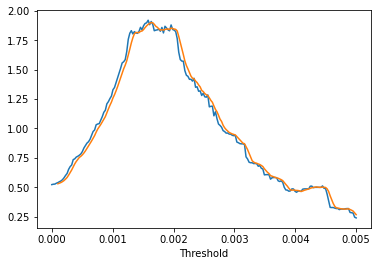

In [51]:
#Find optimal threshold based on train data, doesnt really work since model knows this data too well, cant generalize this threshold
ret, thresh = BackTestOpt(Xopt_rf)
print(round(thresh,5))

0.00095


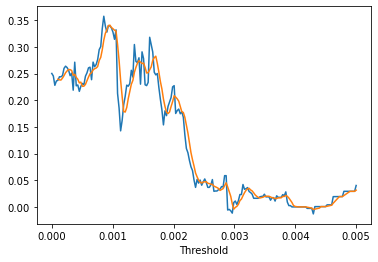

In [52]:
#Finding Optimal Threshold based on test data, cant do this in reality, would need to have other sets of data to optimize threshold on
ret, thresh = BackTestOpt(XTrade_rf)
print(round(thresh,5))

## Gradient Boosted Trees

In [53]:
XTrade_xgb, Xopt_xgb = prep_data(xgbreg_best)

0.00188


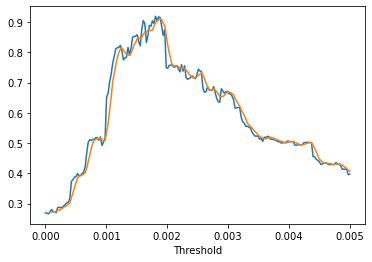

In [54]:
#Find optimal threshold based on train data, doesnt really work since model knows this data too well, cant generalize this threshold
ret, thresh = BackTestOpt(Xopt_xgb)
print(round(thresh,5))

0.00138


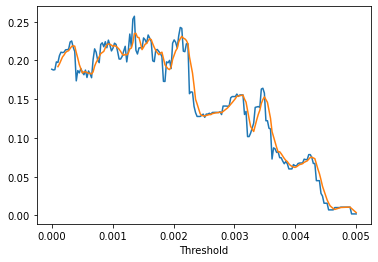

In [55]:
#Finding Optimal Threshold based on test data, cant do this in reality, would need to have other sets of data to optimize threshold on
ret, thresh = BackTestOpt(XTrade_xgb)
print(round(thresh,5))

# Trading Results

In [61]:
def get_trading_results(data, threshold, model_name, short=False):
    #Backtest on test data with optimal or manual threshold
    XTrade, strat_ann_vol, strat_ann_ret, strat_ann_sr, strat_ann_cagr, \
        long_ann_vol, long_ann_ret, long_ann_sr, long_ann_cagr \
        = BackTest(data, threshold, short)
    
    print("Strategy Results: Annualized Volatility: %0.4f Annualized Returns: %0.4f Sharpe Ratio: %0.4f CAGR: %0.4f" \
          % (round(strat_ann_vol,4), round(strat_ann_ret,4), round(strat_ann_sr,4), round(strat_ann_cagr,4)))
    print("Equal Long Portfolio Results: Annualized Volatility: %0.4f Annualized Returns: %0.4f Sharpe Ratio: %0.4f CAGR: %0.4f" \
          % (round(long_ann_vol,4), round(long_ann_ret,4), round(long_ann_sr,4), round(long_ann_cagr,4)))
    
    # Summarize results for random forest portfolio
    XTrade['STRAT_CUMRET'].shift(periods=1).plot(figsize=(5,3))
    XTrade['LONG_CUMRET'].plot(figsize=(5,3))
    plt.legend([model_name+' Portfolio', 'Equal Portfolio'], loc="upper left")
    plt.title(model_name+' Portfolio vs Equal Portfolio')
    plt.ylabel("Cumulative Return")
    plt.show()    

Strategy Results: Annualized Volatility: 0.1265 Annualized Returns: 0.1983 Sharpe Ratio: 1.4308 CAGR: 0.1811
Equal Long Portfolio Results: Annualized Volatility: 0.1181 Annualized Returns: 0.2025 Sharpe Ratio: 1.5615 CAGR: 0.1846


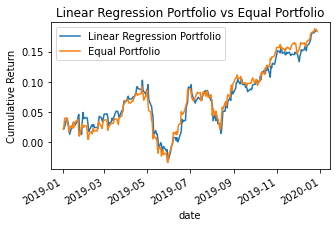

In [62]:
# Linear Regression
threshold_lr = 0.0001 #used this based on approximating form previous tests, adds buffer for predictions around 0
short = False
#Threshold = thresh
get_trading_results(XTrade_lr, threshold_lr, "Linear Regression", short)

Strategy Results: Annualized Volatility: 0.1449 Annualized Returns: 0.2612 Sharpe Ratio: 1.6027 CAGR: 0.2324
Equal Long Portfolio Results: Annualized Volatility: 0.1181 Annualized Returns: 0.2025 Sharpe Ratio: 1.5615 CAGR: 0.1846


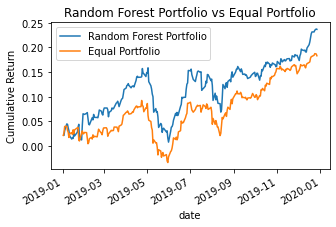

In [63]:
# Random Forest
threshold_rf = 0.0003 #used this based on approximating form previous tests, adds buffer for predictions around 0
short = False
#Threshold = thresh
get_trading_results(XTrade_rf, threshold_rf, "Random Forest", short)

Strategy Results: Annualized Volatility: 0.1190 Annualized Returns: 0.2095 Sharpe Ratio: 1.5987 CAGR: 0.1904
Equal Long Portfolio Results: Annualized Volatility: 0.1181 Annualized Returns: 0.2025 Sharpe Ratio: 1.5615 CAGR: 0.1846


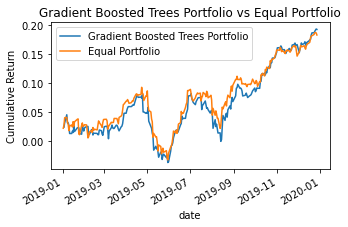

In [64]:
# Gradient Boosted Trees
threshold_xgb = 0.001 #used this based on approximating form previous tests, adds buffer for predictions around 0
short = False
#Threshold = thresh
get_trading_results(XTrade_xgb, threshold_xgb, "Gradient Boosted Trees", short)

In [60]:
#White's Reality Check
def WRC():
    
    return()